# Part 3: Categories Analyze

### In this part we created new features of average and mean for category, backers and goal columns.

## Imports & Configurations

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -O ./spark-3.3.1-bin-hadoop3.tgz  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
!tar zxvf ./spark-3.3.1-bin-hadoop3.tgz
!pip install findspark
!pip install pyspark

--2023-02-26 09:05:16--  https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz
Resolving dlcdn.apache.org (dlcdn.apache.org)... 151.101.2.132, 2a04:4e42::644
Connecting to dlcdn.apache.org (dlcdn.apache.org)|151.101.2.132|:443... connected.
HTTP request sent, awaiting response... 404 Not Found
2023-02-26 09:05:17 ERROR 404: Not Found.


gzip: stdin: unexpected end of file
tar: Child returned status 1
tar: Error is not recoverable: exiting now
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 281.4/281.4 MB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 199.7/199.7 KB 21.2 MB/s eta 0:00:00
  Created wheel for pyspark: filename=pyspark-3.3.2-py2.py3-none-any.whl size=281824025 sha256=26364dbf423222d03e11c8b99d59eef688cbd89e

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

import findspark
import pyspark

from pyspark.sql import SparkSession
from pyspark.sql import functions as F
from pyspark.sql import types as T

%matplotlib inline
import seaborn as sns
import matplotlib.pyplot as plt

In [23]:
spark = SparkSession.builder.config("spark.driver.memory", "2g")\
    .config("spark.executor.memory", "2g") \
    .config('spark.executor.cores', '3') \
    .config('spark.cores.max', '3') \
    .appName("categories").getOrCreate()

spark.conf.set("spark.sql.shuffle.partitions", 10)
spark.conf.set("spark.default.parallelism", 10)

##Read The Data

In [5]:
# Use Spark to read the csv file.
df = spark.read.csv("/content/drive/MyDrive/BDP Final Project/Notebooks/Data/timing_data.csv",
                    inferSchema=True,
                    header=True,
                    escape='"')

In [6]:
df.show()

+----------+---------------------+--------------------+-------------+-----------+-----------------+------------------+--------------------+--------+--------+-------+----------------+-------------------+--------------+-------------------+-----------------+-------------------+----------------------+----------------------+---------------------+------------+---------+----------+----------------+--------------+-------------+----------------+-------------+------------------------------+------------------------------+----------+-----------+-------------------+--------------------------+--------------+----------------------+--------------------+-------------------+-------------------+------------------------------------+---------------------------+------------------+---------------+----------------+----------------------+----------------+-----------------+------------------------+----------------+-----------------------+-------------+--------------+---------------------+-------------+---------

# Part 3.1: Analyze Categories 

## Create new features by Category

In [7]:
categories_data = df\
.groupBy('category_name','category_parent_name')\
.agg(
    F.avg(F.cast('int',F.col('backers_count'))).alias("avg_backers_count_per_category"),
    F.avg(F.cast('int',F.col('goal'))).alias("avg_goal_per_category"),
    F.count(F.col('category_name')).alias("count_category"),
    F.sum(F.when(F.col('state') == 'successful' , 1).otherwise(0)).alias("success_count_per_category")
    )

In [8]:
categories_data.show()

+--------------+--------------------+------------------------------+---------------------+--------------+--------------------------+
| category_name|category_parent_name|avg_backers_count_per_category|avg_goal_per_category|count_category|success_count_per_category|
+--------------+--------------------+------------------------------+---------------------+--------------+--------------------------+
|          Toys|              Design|            429.01960784313724|   16896.803921568626|           102|                        57|
|      Hardware|          Technology|              520.345886205485|    71811.14604584526|          2443|                      1466|
|        Flight|          Technology|            234.90263157894736|   122753.94473684211|           380|                        80|
|         Sound|          Technology|             386.7779171894605|    66949.42158092848|           797|                       415|
|Conceptual Art|                 Art|            32.140964995269634| 

In [9]:
categories_data = categories_data.withColumn(
    'success_percent_per_category', F.col('success_count_per_category') / F.col('count_category')
).drop('success_count_per_category').drop('count_category')

In [10]:
categories_data.show()

+--------------+--------------------+------------------------------+---------------------+----------------------------+
| category_name|category_parent_name|avg_backers_count_per_category|avg_goal_per_category|success_percent_per_category|
+--------------+--------------------+------------------------------+---------------------+----------------------------+
|          Toys|              Design|            429.01960784313724|   16896.803921568626|          0.5588235294117647|
|      Hardware|          Technology|              520.345886205485|    71811.14604584526|          0.6000818665575113|
|        Flight|          Technology|            234.90263157894736|   122753.94473684211|         0.21052631578947367|
|         Sound|          Technology|             386.7779171894605|    66949.42158092848|           0.520702634880803|
|Conceptual Art|                 Art|            32.140964995269634|    51035.37627246925|         0.41721854304635764|
|         Farms|                Food|   

In [11]:
df = df.join(categories_data,['category_name','category_parent_name'],'left')

In [12]:
df = df.na.drop(how="any")

##Create new features by Parent Category

In [13]:
categories_data = df\
.groupBy('category_parent_name')\
.agg(
    F.avg(F.cast('int',F.col('backers_count'))).alias("avg_backers_count_per_parent_category"),
    F.avg(F.cast('int',F.col('goal'))).alias("avg_goal_per_parent_category"),
    F.count(F.col('category_name')).alias("count_parent_category"),
    F.sum(F.when(F.col('state') == 'successful' , 1).otherwise(0)).alias("success_count_per_parent_category")
    )

In [14]:
categories_data = categories_data.withColumn(
    'success_percent_per_parent_category', F.col('success_count_per_parent_category') / F.col('count_parent_category')
).drop('success_count_per_parent_category').drop('count_parent_category')

In [15]:
categories_data.show()

+--------------------+-------------------------------------+----------------------------+-----------------------------------+
|category_parent_name|avg_backers_count_per_parent_category|avg_goal_per_parent_category|success_percent_per_parent_category|
+--------------------+-------------------------------------+----------------------------+-----------------------------------+
|         Photography|                    51.29555924083287|          14292.697070204533|                 0.3637368711995578|
|              Crafts|                   26.307034022124817|           36043.32456689626|                0.28115216030056356|
|             Fashion|                   113.91746660069272|           18063.29272637308|                 0.6225630875804058|
|              Comics|                    216.2243698576466|           9356.739584693743|                 0.8367506856471203|
|               Dance|                   41.951541850220266|          10368.867841409692|                 0.5997482693

In [16]:
df = df.join(categories_data,['category_parent_name'],'left')

In [17]:
df.show()

+--------------------+--------------+----------+--------------------+--------------------+-------------+-----------+------------------+--------+--------+-------+----------------+-------------------+--------------+-------------------+-----------------+-------------------+----------------------+----------------------+---------------------+------------+---------+----------+----------------+--------------------+-------------+----------------+-------------+------------------------------+------------------------------+----------+-----------+-------------------+--------------------------+--------------+----------------------+--------------------+-------------------+-------------------+------------------------------------+---------------------------+------------------+---------------+----------------+----------------------+----------------+-----------------+------------------------+----------------+-----------------------+-------------+--------------+---------------------+-------------+-------

## Save CSV

In [18]:
df.write.csv("/content/drive/MyDrive/BDP Final Project/Notebooks/Data/categories_data.csv", header=True, mode ="overwrite")

# Part 3.1: Data Visualization

In [19]:
data = df.select(
    ['category_parent_name','category_name', 
     'avg_backers_count_per_category', 'avg_goal_per_category', 'success_percent_per_category',
    'avg_backers_count_per_parent_category','avg_goal_per_parent_category','success_percent_per_parent_category'
     ])\
    .toPandas()

categories_data = df.select(
['category_parent_name','category_name', 
  'avg_backers_count_per_category', 'avg_goal_per_category', 'success_percent_per_category'
  ])\
.toPandas()

parent_categories_data = df.select(
['category_parent_name', 
  'avg_backers_count_per_parent_category', 'avg_goal_per_parent_category', 'success_percent_per_parent_category'
  ])\
.toPandas()

Plotting backers and goal average to category:

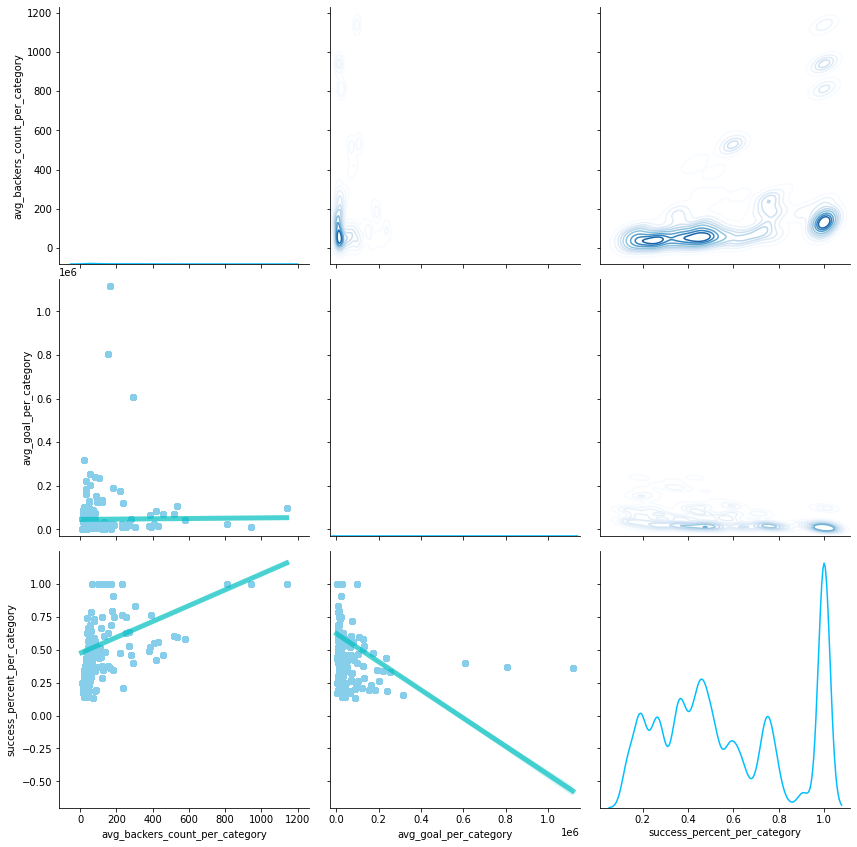

In [20]:
g = sns.PairGrid(categories_data, palette='GnBu',height=4,)
g = g.map_upper(sns.kdeplot, cmap = plt.cm.Blues)
g = g.map_lower(sns.regplot, line_kws={"color":"c","alpha":0.7,"lw":5}, color = 'skyblue')
g = g.map_diag(sns.kdeplot, color = 'deepskyblue')
g

Plotting backers and pledged mean to category:

<ipython-input-21-03376c3b428b>:8: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)


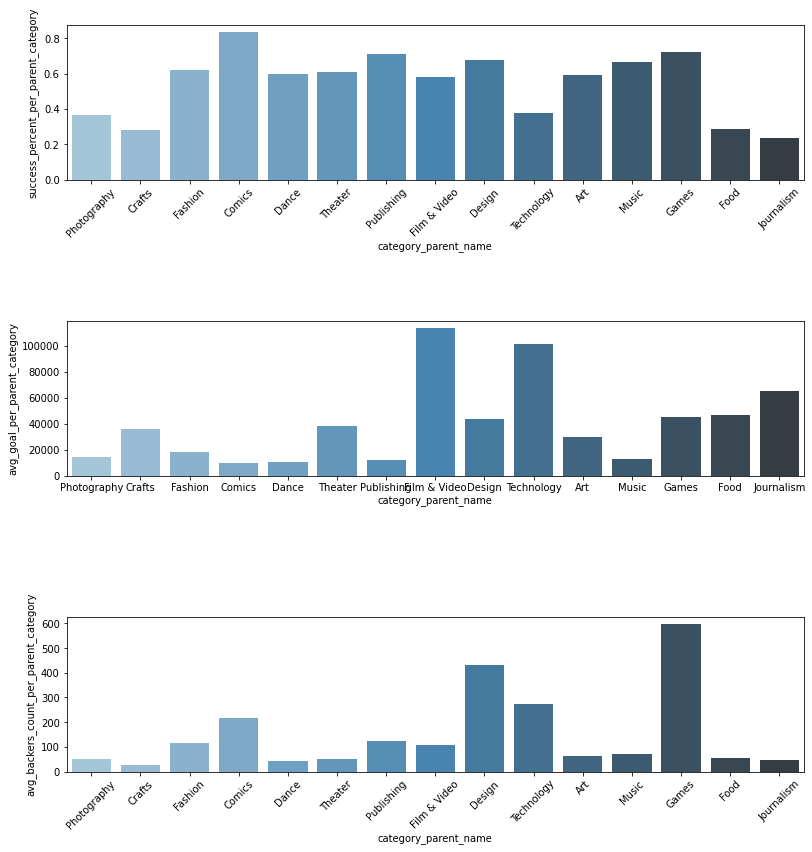

In [21]:
fig , ((ax1),(ax2),(ax3)) = plt.subplots(nrows=3,ncols=1,figsize = (14,14))
fig.tight_layout(pad=12.0)

sns.barplot(x="category_parent_name", y="success_percent_per_parent_category", data=data,palette="Blues_d", ax=ax1)
ax1.set_xticklabels(ax1.get_xticklabels(), rotation=45)

sns.barplot(x="category_parent_name", y="avg_goal_per_parent_category", data=data,palette="Blues_d", ax=ax2)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

sns.barplot(x="category_parent_name", y="avg_backers_count_per_parent_category", data=data,palette="Blues_d", ax=ax3)
ax3.set_xticklabels(ax3.get_xticklabels(), rotation=45)

plt.show()


In [25]:
spark.stop()

#Part 3.2: Conclusion

### * Category have an impact on the success of the project.
### * It's better to create a project in a category that attract backers, number of backers is realy important to success.
### * Set a low goal to your project.
### * Games categoty get the most high average backers.
